In [1]:


# folder with pictures
ROOT_DIR = r'C:\Users\Shadow\Pictures\Geogussr\Projekt'

# dir to csv files
dir = r"C:\Users\Shadow\Documents\sequentialmodel\preprocess"

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
#from torchsummary import summary
from torch.optim import lr_scheduler


# Dataset
from GeoGuessrDataset import GeoGuessrDataset


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tnrange
import time
import copy
import pygeohash as phg


%matplotlib inline

# Enable autoreloading of imported modules.
%load_ext autoreload
%autoreload 2

In [3]:

# Check GPU support on your machine.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)


cuda:0


In [4]:

# from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models.resnet import resnet50, ResNet50_Weights


# New weights with accuracy 80.858%
resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
resnet50(weights=ResNet50_Weights.DEFAULT)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Preprocessing and continent selection

In [5]:
df = pd.read_csv(dir+"\\final_contis_merged.csv", delimiter=',', skiprows=0, low_memory=False)

def encode_geohashes(df, continent_name = None, drop_some = False):
    
    if continent_name:
        # get csv to only contain one continent
        keys = df["continent"].unique()
        indices = {key: df.index[df["continent"]==key].tolist()for key in keys}
        df = df.iloc[indices[continent_name]]

        # We want a geohash precsion of 3 so that we get approximately 32768 cells, which will represent our classes.
        df['geohash']=df.apply(lambda coords: phg.encode(coords.latitude, coords.longitude, precision=3), axis=1)

        # get all hashes that contain samples
        geohashes_with_samples = df["geohash"].unique()                 
        num_geohashes_with_samples = len(geohashes_with_samples)
        print("Number of geohashes with samples", num_geohashes_with_samples)
        
        # test for dropping geohashes that contain less than 3 samples
        if drop_some == True:
            counts = df["geohash"].value_counts()
            to_drop = counts[counts>=3].index
            print("number of geohashes with 3 or more samples:", len(to_drop))
            df= df[df["geohash"].isin(to_drop)]
            geohashes_with_samples = df["geohash"].unique()
            num_geohashes_with_samples = len(geohashes_with_samples)
            
        # map the geohashes with samples to cluster_numbers
        geohash_map = { geo: i for i, geo in enumerate(geohashes_with_samples)}
        df["geo_code"] = df.apply(lambda geohash: geohash_map[geohash["geohash"]], axis=1)

        # those values are not needed, but we have to keep the number of columns the same for the dataloader
        df["geohash_decimal"] = np.nan
        
    else:
        num_geohashes_with_samples = len(df["geo_code"].unique())
        
        # We want a geohash precsion of 3 so that we get approximately 32768 cells, which will represent our classes.
        df['geohash']=df.apply(lambda coords: phg.encode(coords.latitude, coords.longitude, precision=3), axis=1)
        
        print("Number of geohashes with samples", num_geohashes_with_samples)
        
    # save as csv
    df[["filename", "latitude", "longitude", "geohash_decimal", "geo_code", "continent", "conti_code"]].to_csv(dir+"\coordinates3.csv", index=False)
    
    return df, num_geohashes_with_samples

# create another csv with the coordinates of the centers of each geohash
def geohash_center(geohash_name):

    # Decode the geohash to get the center coordinates and errors.
    latitude, longitude, latitude_error, longitude_error = phg.decode_exactly(geohash_name)
    return [latitude, longitude]




# encode geohashes for chosen continent (ommit continent and drop_some if we want to train all data)
df, fc_size = encode_geohashes(df, drop_some = False)

# compute the center coordinates of each geohash
df["geo_lat"], df["geo_lon"] = df.apply(lambda x: geohash_center(x["geohash"])[0] ,axis=1), df.apply(lambda x: geohash_center(x["geohash"])[1] ,axis=1)

# drop the duplicates
df = df.drop(columns=["filename", "latitude", "longitude","geohash_decimal","geohash", "continent", "conti_code"] )
df = df.drop_duplicates()

# do we use the tensor?
array = df.to_numpy()
array = np.array(array, dtype=np.float64)
tensor = torch.tensor(array)
torch.save(tensor, dir+'\\tensor.pt')

# Save the DataFrame to a CSV file.
df[["geo_code", "geo_lat", "geo_lon"]].to_csv(dir+"\coords_center.csv", index=False)



Number of geohashes with samples 3139


In [6]:
df = pd.read_csv(dir+"\\coordinates3.csv", delimiter=',', skiprows=0, low_memory=False)
print(fc_size)
print(df["latitude"].size*0.9)

3139
103009.6


In [7]:
# Define the data transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # normalize images
    transforms.Resize((250, 1000))
])

# Load the dataset and split it into training and validation sets (fc_size is generated in the kernel above)
dataset = GeoGuessrDataset(csv_file=dir+'\coordinates3.csv',
                                    root_dir=ROOT_DIR, transform=transform, num_classes=fc_size, indices=None)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size],generator=torch.Generator(
).manual_seed(42))
print(len(train_dataset))
# Define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

dataloaders = {"train" : train_dataloader, "val": val_dataloader}
dataset_sizes = {"train": train_size, "val" : val_size}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

103009


## Sanity check for continent selection

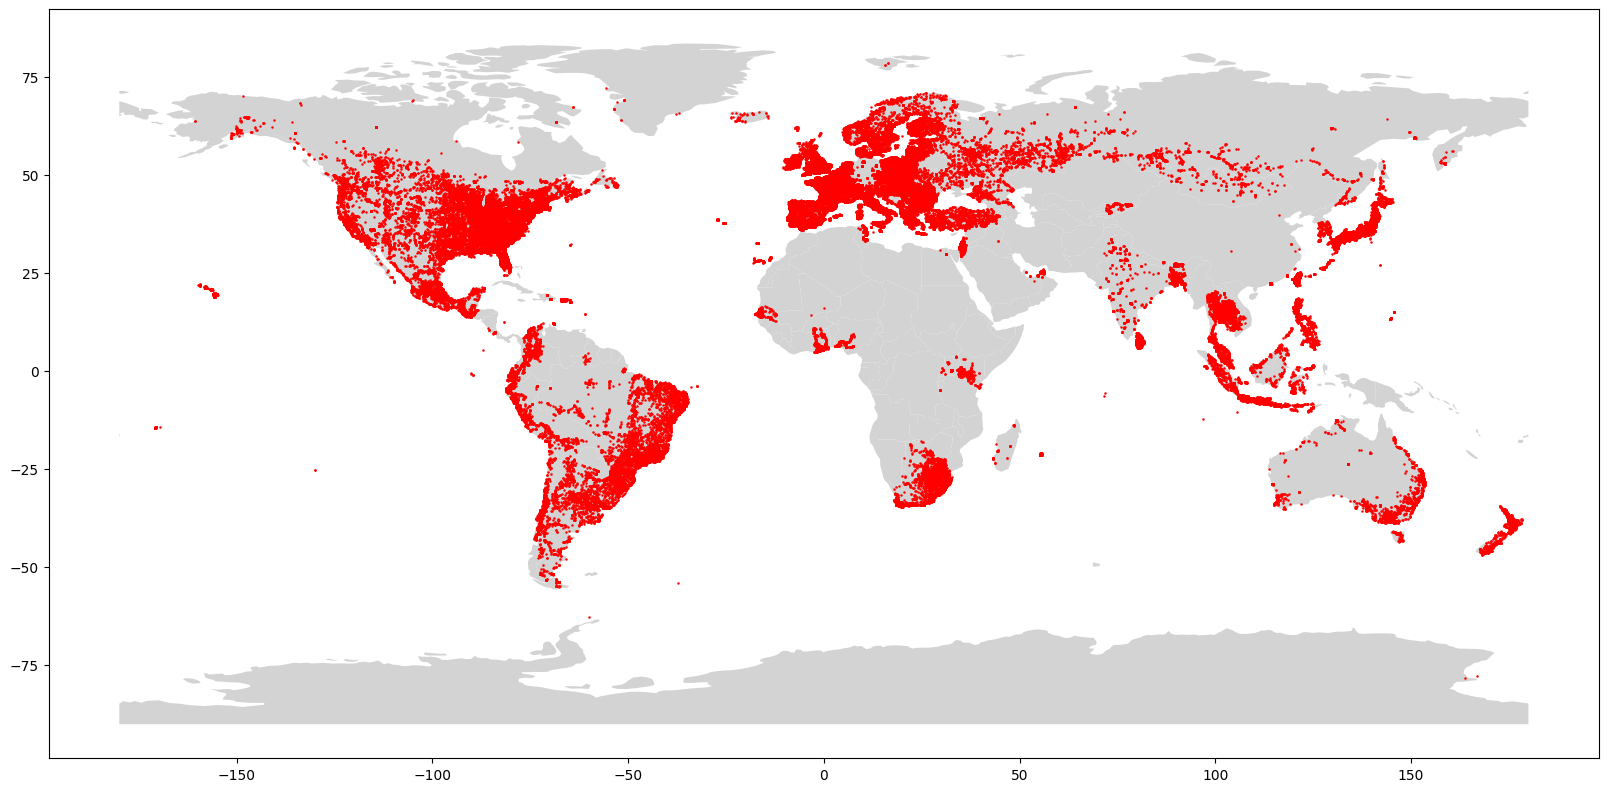

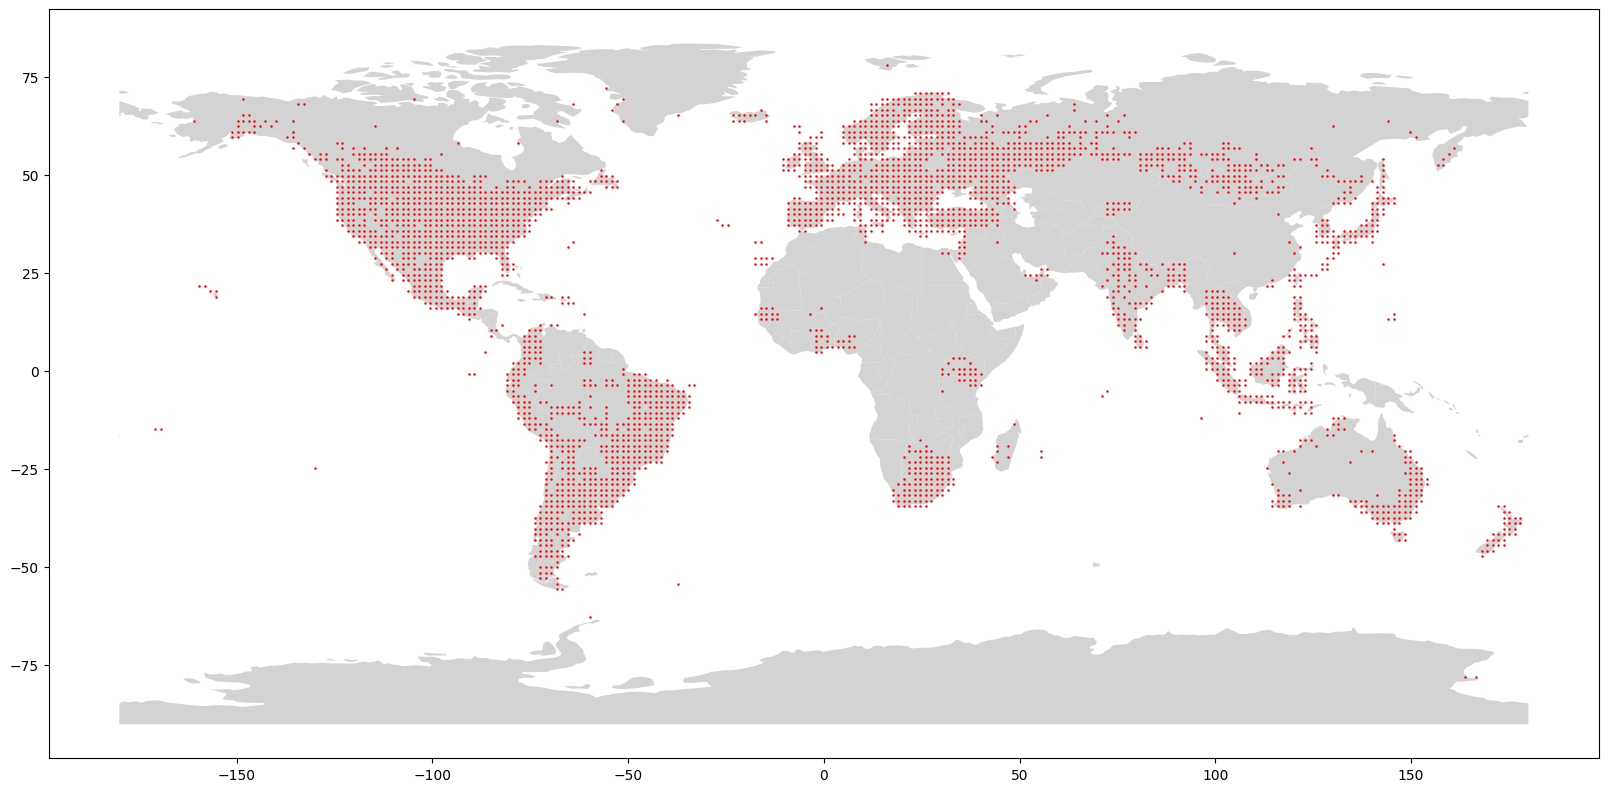

In [8]:
import geopandas as gpd
plt.rcParams["figure.dpi"] = 100

df = pd.read_csv(dir+"\\coordinates3.csv", delimiter=',', skiprows=0, low_memory=False)

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))


countries.plot(color="lightgrey", figsize = (20, 16))


plt.scatter(df["longitude"], df["latitude"], c='red', s = 0.6)
plt.show()

df = pd.read_csv(dir+"\\coords_center.csv", delimiter=',', skiprows=0, low_memory=False)

countries = gpd.read_file(
               gpd.datasets.get_path("naturalearth_lowres"))


countries.plot(color="lightgrey", figsize = (20, 16))


plt.scatter(df["geo_lon"], df["geo_lat"], c='red', s = 0.6)
plt.show()


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    torch.backends.cudnn.benchmark = True
    
    best_acc = 0.0
     
    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    val_loss_history = []
    epoch_dist = []
    
    ######################
    # single batch test
    #batch=next(iter(dataloaders["train"]))
    
    ##############################
    for epoch in (pbar := tnrange(num_epochs)):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_dist = 0.0
            # Iterate over data.
            for idx, batch in enumerate(dataloaders[phase]):
                inputs, labels, gt  = batch["image"], batch["geohash"], batch['gt']
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    loss = criterion(outputs, labels.float())

                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()

                        optimizer.step()
                _,labels = torch.max(labels, 1)
                # statistics
                running_loss += loss.item() * inputs.size(0)
                #running_dist += criterion1(outputs, gt, labels).item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            if phase == 'train':
                scheduler.step()
            
            ################################################
            #adjust for single batch testing
            #epoch_distance = running_dist / dataset_sizes[phase]
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            ###############################################################
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Dist: ')

            
                
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                
             # deep copy the model
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                PATH3 = r"C:\Users\Shadow\Documents\DLCV_Project_GeoGuessr_AI-Basti\models\pretrainedresnet50_14epoch_Europe_Dropout.tar"
                torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'val_loss_history': val_loss_history,
                'val_acc_history': val_acc_history,
                'train_loss_history' : train_loss_history,
                'train_acc_history' : train_acc_history
                }, PATH3)

        print()
    
    PATH3 = r"C:\Users\Shadow\Documents\DLCV_Project_GeoGuessr_AI-Basti\models\pretrainedresnet50_14epoch_Europe_Dropout_stats.tar"
    torch.save({
    'val_loss_history': val_loss_history,
    'val_acc_history': val_acc_history,
    'train_loss_history' : train_loss_history,
    'train_acc_history' : train_acc_history
    }, PATH3)

    
    print(f'Best val Acc: {best_acc:4f}')

    
    return model

In [13]:
model_ft = models.resnet50(weights=ResNet50_Weights.DEFAULT)
# model_ft = models.resnet18()

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs,fc_size)


model_ft = model_ft.to(device)


 

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.0001)

# Decay LR by a factor of 0.5 every 6 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.5)


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=14)

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/14
----------


In [ ]:
model_ft = models.resnet50(weights=ResNet50_Weights.DEFAULT)
# model_ft = models.resnet18()

num_ftrs = model_ft.fc.in_features


model_ft.fc = nn.Linear(num_ftrs, fc_size)

model_ft = model_ft.to(device)



In [ ]:
from utils import show_training
checkpoint = torch.load(r"C:\Users\Shadow\Documents\DLCV_Project_GeoGuessr_AI-Basti\models\pretrainedresnet50_14epoch_Europe_Dropout_stats.tar")

history = {'loss':checkpoint['train_loss_history'], 'train_acc':checkpoint['train_acc_history'],'val_acc':checkpoint['val_acc_history']}

show_training(history)